Импорт библиотек

In [1]:
import pandas as pd
from sqlalchemy import create_engine

Подключение к базе данных

In [2]:
# устанавливаем параметры
db_config = {'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения
'db': 'data-analyst-final-project-db'} # название базы данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
 db_config['pwd'],
 db_config['host'],
 db_config['port'],
 db_config['db'])
# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

## Обзор таблиц

Таблица `books`

In [3]:
query = """ 
SELECT *
FROM books
LIMIT 5;
"""
books = pd.io.sql.read_sql(query, con = engine)

In [4]:
display(books)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


Таблица `authors`

In [5]:
query = """ 
SELECT *
FROM authors
LIMIT 5;
"""
books = pd.io.sql.read_sql(query, con = engine)

In [6]:
display(books)

,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


Таблица `publishers`

In [7]:
query = """ 
SELECT *
FROM publishers
LIMIT 5;
"""
books = pd.io.sql.read_sql(query, con = engine)

In [8]:
display(books)

,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


Таблица `ratings`

In [9]:
query = """ 
SELECT *
FROM ratings
LIMIT 5;
"""
books = pd.io.sql.read_sql(query, con = engine)

In [10]:
display(books)

,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


Таблица `reviews`

In [11]:
query = """ 
SELECT *
FROM reviews
LIMIT 5;
"""
books = pd.io.sql.read_sql(query, con = engine)

In [12]:
display(books)

,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...


## Анализ базы

После 1 января 2000 вышло 818 книг.

In [13]:
query = """ 
SELECT COUNT(book_id)
FROM books
WHERE DATE_TRUNC('month', CAST(publication_date AS timestamp)) > '2000-01-01';
"""


books = pd.io.sql.read_sql(query, con = engine)

In [14]:
print(books)

   count
0    818


Практически половина книг имеет по 2 обзора. Самая часто получаемая оценка - 4 балла. Далее по уменьшению количества оценок получаемых книгами: 4.5, 3.5, 3, 5 и д.т. 

In [15]:
query = """ 
SELECT books_reviews.book_id,
       books_reviews.reviews_number,
       AVG(r.rating) AS ratings_avg
       
FROM (SELECT b.book_id,
       COUNT(rv.review_id) AS reviews_number      
       FROM books as b
       LEFT JOIN reviews as rv on b.book_id = rv.book_id
       GROUP BY b.book_id) AS books_reviews
LEFT JOIN ratings as r on books_reviews.book_id = r.book_id
GROUP BY books_reviews.book_id, books_reviews.reviews_number;
"""


books = pd.io.sql.read_sql(query, con = engine)

In [16]:
display(books.head(10))

,book_id,reviews_number,ratings_avg
0,967,2,5.000000
1,716,2,3.000000
2,163,3,3.000000
3,680,4,4.250000
4,583,4,4.142857
5,85,4,3.250000
6,448,2,4.500000
7,236,2,4.500000
8,177,4,4.100000
9,499,2,3.000000


In [17]:
print(books['reviews_number'].sum())
print(books['book_id'].nunique())

2793
1000


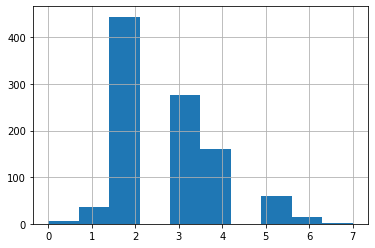

In [18]:
books['reviews_number'].hist();

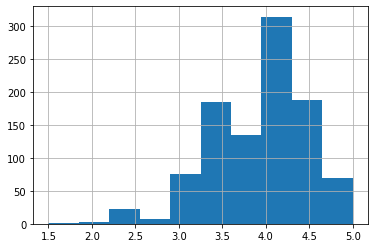

In [19]:
books['ratings_avg'].hist();

Наибольшее число книг (толще 50 страниц) выпустило издательство Penguin Books - 42 книги.

In [20]:
query = """ 
SELECT p.publisher,
       COUNT(b.title)
FROM publishers as p
RIGHT JOIN books as b on b.publisher_id = p.publisher_id
WHERE b.num_pages >= 50
GROUP BY publisher
ORDER BY COUNT(b.title) DESC
LIMIT 5;
"""

books = pd.io.sql.read_sql(query, con = engine)

In [21]:
display(books)

,publisher,count
0,Penguin Books,42
1,Vintage,31
2,Grand Central Publishing,25
3,Penguin Classics,24
4,Bantam,19


Самая высокая оценка у автора J.K. Rowling/Mary GrandPré - 4,4 среди авторов книги, которых набрали более 50 оценок.

In [22]:
query = """ 
SELECT a.author,
       AVG(r.rating) AS rating_avg,
       b.title,
       COUNT(r.rating) AS rating_number
FROM authors as a
RIGHT JOIN books as b on a.author_id = b.author_id
FULL OUTER JOIN ratings as r on b.book_id = r.book_id
GROUP BY a.author, r.book_id, b.title
HAVING COUNT(r.rating) >= 50
ORDER BY AVG(r.rating) DESC
LIMIT 5;
"""

books = pd.io.sql.read_sql(query, con = engine)

In [23]:
display(books)

,author,rating_avg,title,rating_number
0,J.K. Rowling/Mary GrandPré,4.414634,Harry Potter and the Prisoner of Azkaban (Harr...,82
1,J.R.R. Tolkien,4.391892,The Fellowship of the Ring (The Lord of the Ri...,74
2,J.K. Rowling/Mary GrandPré,4.287500,Harry Potter and the Chamber of Secrets (Harry...,80
3,Markus Zusak/Cao Xuân Việt Khương,4.264151,The Book Thief,53
4,J.K. Rowling/Mary GrandPré,4.246575,Harry Potter and the Half-Blood Prince (Harry ...,73


Среднее количество обзоров от пользователей, которые поставили больше 50 оценок - 24.2

In [24]:
query = """ 
SELECT AVG(number.reviews_count)
FROM (SELECT COUNT(review_id) AS reviews_count
      FROM reviews
      WHERE username IN ( SELECT username
                          FROM ratings 
                          GROUP BY username
                          HAVING COUNT(rating_id) >= 50)
                          GROUP BY username) AS number

"""

books = pd.io.sql.read_sql(query, con = engine)

In [25]:
display(books)

,avg
0,24.222222


## Выводы
После 1 января 2000 вышло 818 книг. Практически половина книг имеет по 2 обзора. Самая часто получаемая оценка - 4 балла. Далее по уменьшению количества оценок получаемых книгами: 4.5, 3.5, 3, 5 и д.т. Наибольшее число книг (толще 50 страниц) выпустило издательство Penguin Books - 42 книги. Самая высокая оценка у автора J.K. Rowling/Mary GrandPré - 4,4 среди авторов книги, которых набрали более 50 оценок. Среднее количество обзоров от пользователей, которые поставили больше 50 оценок - 24,2.